
<a id='lu-tricks'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Classical Control with Linear Algebra

## Contents

- [Classical Control with Linear Algebra](#Classical-Control-with-Linear-Algebra)  
  - [Overview](#Overview)  
  - [A Control Problem](#A-Control-Problem)  
  - [Finite Horizon Theory](#Finite-Horizon-Theory)  
  - [The Infinite Horizon Limit](#The-Infinite-Horizon-Limit)  
  - [Undiscounted Problems](#Undiscounted-Problems)  
  - [Implementation](#Implementation)  
  - [Exercises](#Exercises)  

## Overview

In an earlier lecture [Linear Quadratic Dynamic Programming Problems](dynamic_programming/lqcontrol.html) we have studied how to solve a special
class of dynamic optimization and prediction problems by applying the method of dynamic programming. In this class of problems

> - the objective function is **quadratic** in **states** and **controls**  
- the one-step transition function is **linear**  
- shocks are i.i.d. Gaussian or martingale differences  



In this lecture and a companion lecture [Classical Filtering with Linear Algebra](classical_filtering.html), we study the classical theory of linear-quadratic (LQ) optimal control problems.

The classical approach does not use the two closely related methods – dynamic programming and  Kalman filtering – that we describe in other lectures, namely, [Linear Quadratic Dynamic Programming Problems](dynamic_programming/lqcontrol.html) and [A First Look at the Kalman Filter](tools_and_techniques/kalman.html)

Instead they use either

> - $ z $-transform and lag operator methods, or  
- matrix decompositions applied to linear systems of first-order conditions for optimum problems.  



In this lecture and the sequel [Classical Filtering with Linear Algebra](classical_filtering.html), we mostly rely on  elementary linear algebra

The main tool from linear algebra we’ll put to work here is [LU decomposition](https://en.wikipedia.org/wiki/LU_decomposition)

We’ll begin with discrete horizon problems

Then we’ll view infinite horizon problems as appropriate limits of these finite horizon problems

Later, we will examine the close connection between LQ control and least squares prediction and filtering problems

These classes of problems are connected in the sense that to solve each, essentially the same mathematics is used

### References

Useful references include [[Whi63]](zreferences.html#whittle1963), [[HS80]](zreferences.html#hansar1980), [[Orf88]](zreferences.html#orfanidisoptimum1988), [[AP91]](zreferences.html#athanasios1991), and [[Mut60]](zreferences.html#muth1960)

### Setup

In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag = "v0.9.8");

In [2]:
using Polynomials, Plots, Random, Parameters
using LinearAlgebra, Statistics, Compat

## A Control Problem

Let $ L $ be the **lag operator**, so that, for sequence $ \{x_t\} $ we have $ L x_t = x_{t-1} $

More generally, let $ L^k x_t = x_{t-k} $ with $ L^0 x_t = x_t $ and

$$
d(L) = d_0 + d_1 L+ \ldots + d_m L^m
$$

where $ d_0, d_1, \ldots, d_m $ is a given scalar sequence

Consider the discrete time control problem


<a id='equation-oneone'></a>
$$
\max_{\{y_t\}}
\lim_{N \to \infty} \sum^N_{t=0} \beta^t\,
\left\{
     a_t y_t - {1 \over 2}\, hy^2_t - {1 \over 2} \,
         \left[ d(L)y_t \right]^2
\right\}, \tag{1}
$$

where

- $ h $ is a positive parameter and $ \beta \in (0,1) $ is a discount factor  
- $ \{a_t\}_{t \geq 0} $ is a sequence of exponential order less than $ \beta^{-1/2} $, by which we mean $ \lim_{t \rightarrow \infty} \beta^{\frac{t}{2}} a_t = 0 $  


Maximization in [(1)](#equation-oneone) is subject to  initial conditions for $ y_{-1}, y_{-2} \ldots, y_{-m} $

Maximization is over infinite sequences $ \{y_t\}_{t \geq 0} $

### Example

The formulation of the LQ problem given above is broad enough to encompass
many useful models

As a simple illustration, recall that in [lqcontrol](dynamic_programming/lqcontrol.html) we consider a monopolist facing stochastic demand
shocks and adjustment costs

Let’s consider a deterministic version of this problem, where the monopolist
maximizes the discounted sum

$$
\sum_{t=0}^{\infty} \beta^t \pi_t
$$

and

$$
\pi_t = p_t q_t - c q_t - \gamma (q_{t+1} - q_t)^2
\quad \text{with} \quad
p_t = \alpha_0 - \alpha_1 q_t + d_t
$$

In this expression, $ q_t $ is output, $ c $ is average cost of production, and $ d_t $ is a demand shock

The term $ \gamma (q_{t+1} - q_t)^2 $ represents adjustment costs

You will be able to confirm that the objective function can be rewritten as [(1)](#equation-oneone) when

- $ a_t := \alpha_0 + d_t - c $  
- $ h := 2 \alpha_1 $  
- $ d(L) := \sqrt{2 \gamma}(I - L) $  


Further examples of this problem for factor demand, economic growth, and government policy problems are given in ch. IX of [[Sar87]](zreferences.html#sargent1987)

## Finite Horizon Theory

We first study a finite $ N $ version of the problem

Later we will study an infinite horizon problem solution as a limiting version of a finite horizon problem

(This will require being careful because the limits as $ N \to \infty $ of the necessary and sufficient conditions for maximizing finite $ N $ versions of [(1)](#equation-oneone)
are not sufficient for maximizing [(1)](#equation-oneone))

We begin by

1. fixing $ N > m $,  
1. differentiating the finite version of [(1)](#equation-oneone) with respect to $ y_0, y_1, \ldots, y_N $, and  
1. setting these derivatives to zero  


For $ t=0, \ldots, N-m $ these first-order necessary conditions are the
*Euler equations*

For $ t = N-m + 1, \ldots, N $, the first-order conditions are a set of
*terminal conditions*

Consider the term

$$
\begin{aligned}
J
& = \sum^N_{t=0} \beta^t [d(L) y_t] [d(L) y_t]
\\
& = \sum^N_{t=0}
    \beta^t \, (d_0 \, y_t + d_1 \, y_{t-1} + \cdots + d_m \, y_{t-m}) \,
               (d_0 \, y_t + d_1 \, y_{t-1} + \cdots  + d_m\, y_{t-m})
\end{aligned}
$$

Differentiating $ J $ with respect to $ y_t $ for
$ t=0,\ 1,\ \ldots,\ N-m $ gives

$$
\begin{aligned}
{\partial {J} \over \partial y_t}
   & = 2 \beta^t \, d_0 \, d(L)y_t +
       2 \beta^{t+1} \, d_1\, d(L)y_{t+1} + \cdots +
       2 \beta^{t+m}\, d_m\, d(L) y_{t+m} \\
   & = 2\beta^t\, \bigl(d_0 + d_1 \, \beta L^{-1} + d_2 \, \beta^2\, L^{-2} +
       \cdots + d_m \, \beta^m \, L^{-m}\bigr)\, d (L) y_t\
\end{aligned}
$$

We can write this more succinctly as


<a id='equation-onetwo'></a>
$$
{\partial {J} \over \partial y_t}
    = 2 \beta^t \, d(\beta L^{-1}) \, d (L) y_t \tag{2}
$$

Differentiating $ J $ with respect to $ y_t $ for $ t = N-m + 1, \ldots, N $ gives


<a id='equation-onethree'></a>
$$
\begin{aligned}
 {\partial J \over \partial y_N}
 &= 2 \beta^N\, d_0 \, d(L) y_N \cr
   {\partial J \over \partial y_{N-1}}
 &= 2\beta^{N-1} \,\bigl[d_0 + \beta \,
   d_1\, L^{-1}\bigr] \, d(L)y_{N-1} \cr
   \vdots
 & \quad \quad \vdots \cr
   {\partial {J} \over \partial y_{N-m+1}}
 &= 2 \beta^{N-m+1}\,\bigl[d_0 + \beta
   L^{-1} \,d_1 + \cdots + \beta^{m-1}\, L^{-m+1}\, d_{m-1}\bigr]  d(L)y_{N-m+1}
\end{aligned} \tag{3}
$$

With these preliminaries under our belts, we are ready to differentiate [(1)](#equation-oneone)

Differentiating [(1)](#equation-oneone) with respect to $ y_t $ for $ t=0, \ldots, N-m $ gives the Euler equations


<a id='equation-onefour'></a>
$$
\bigl[h+d\,(\beta L^{-1})\,d(L)\bigr] y_t = a_t,
\quad t=0,\, 1,\, \ldots, N-m \tag{4}
$$

The system of equations [(4)](#equation-onefour) form  a  $ 2 \times m $ order linear *difference
equation* that must hold for the values of $ t $ indicated.

Differentiating [(1)](#equation-oneone) with respect to $ y_t $ for $ t = N-m + 1, \ldots, N $ gives the terminal conditions


<a id='equation-onefive'></a>
$$
\begin{aligned}
\beta^N  (a_N - hy_N - d_0\,d(L)y_N)
&= 0  \cr
  \beta^{N-1} \left(a_{N-1}-hy_{N-1}-\Bigl(d_0 + \beta \, d_1\,
L^{-1}\Bigr)\, d(L)\, y_{N-1}\right)
& = 0 \cr
 \vdots & \vdots\cr
\beta^{N-m+1} \biggl(a_{N-m+1} - h y_{N-m+1} -(d_0+\beta L^{-1}
d_1+\cdots\  +\beta^{m-1} L^{-m+1} d_{m-1}) d(L) y_{N-m+1}\biggr)
& = 0
\end{aligned} \tag{5}
$$

In the finite $ N $ problem, we want simultaneously to solve [(4)](#equation-onefour) subject to the $ m $ initial conditions
$ y_{-1}, \ldots, y_{-m} $ and the $ m $ terminal conditions
[(5)](#equation-onefive)

These conditions uniquely pin down the solution of the finite $ N $ problem

That is, for the finite $ N $ problem,
conditions [(4)](#equation-onefour) and [(5)](#equation-onefive) are necessary and sufficient for a maximum,
by concavity of the objective function

Next we describe how to obtain the solution using matrix methods


<a id='fdlq'></a>

### Matrix Methods

Let’s look at how linear algebra can be used to tackle and shed light on the finite horizon LQ control problem

#### A Single Lag Term

Let’s begin with the special case in which $ m=1 $

We want to solve the system of $ N+1 $ linear equations


<a id='equation-oneff'></a>
$$
\begin{aligned}
\bigl[h & + d\, (\beta L^{-1})\, d\, (L) ] y_t = a_t, \quad
t = 0,\ 1,\ \ldots,\, N-1\cr
\beta^N & \bigl[a_N-h\, y_N-d_0\, d\, (L) y_N\bigr] = 0
\end{aligned} \tag{6}
$$

where $ d(L) = d_0 + d_1 L $

These equations are to be solved for
$ y_0, y_1, \ldots, y_N $ as functions of
$ a_0, a_1, \ldots,  a_N $ and $ y_{-1} $

Let

$$
\phi (L)
= \phi_0 + \phi_1 L + \beta \phi_1 L^{-1}
= h + d (\beta L^{-1}) d(L)
= (h + d_0^2 + d_1^2) + d_1 d_0 L+ d_1 d_0 \beta L^{-1}
$$

Then we can represent [(6)](#equation-oneff) as the matrix equation


<a id='equation-onefourfive'></a>
$$
\left[
    \begin{matrix}
        (\phi_0-d_1^2) & \phi_1 & 0 & 0 & \ldots & \ldots & 0 \cr
        \beta \phi_1 & \phi_0 & \phi_1 & 0 & \ldots & \dots & 0 \cr
        0 & \beta \phi_1 & \phi_0 & \phi_1 & \ldots & \ldots & 0 \cr
        \vdots &\vdots & \vdots & \ddots & \vdots & \vdots & \vdots \cr
        0 & \ldots & \ldots & \ldots & \beta \phi_1 & \phi_0 &\phi_1 \cr
        0 & \ldots & \ldots & \ldots & 0 & \beta \phi_1 & \phi_0
    \end{matrix}
\right]
\left [
    \begin{matrix}
        y_N \cr y_{N-1} \cr y_{N-2} \cr \vdots \cr
        y_1 \cr y_0
    \end{matrix}
\right ] =
\left[
\begin{matrix}
    a_N \cr a_{N-1} \cr a_{N-2} \cr \vdots \cr a_1 \cr
    a_0 - \phi_1 y_{-1}
\end{matrix}
\right] \tag{7}
$$

or


<a id='equation-onefoursix'></a>
$$
W\bar y = \bar a \tag{8}
$$

Notice how we have chosen to arrange the $ y_t $’s in reverse
time order.

The matrix $ W $ on the left side of [(7)](#equation-onefourfive) is “almost” a
[Toeplitz matrix](https://en.wikipedia.org/wiki/Toeplitz_matrix) (where each
descending diagonal is constant)

There are two sources of deviation from the  form  of a Toeplitz matrix

1. The first element differs from the remaining diagonal elements, reflecting the terminal condition  
1. The subdiagonal elements equal $ \beta $ time the superdiagonal elements  


The solution of [(8)](#equation-onefoursix) can be expressed in the form


<a id='equation-onefourseven'></a>
$$
\bar y = W^{-1} \bar a \tag{9}
$$

which represents each element $ y_t $ of $ \bar y $ as a function of the entire vector $ \bar a $

That is, $ y_t $ is a function of past, present, and future values of $ a $‘s, as well as of the initial condition $ y_{-1} $

#### An Alternative Representation

An alternative way to express the solution to [(7)](#equation-onefourfive) or
[(8)](#equation-onefoursix) is in so called **feedback-feedforward** form

The idea here is to find a solution expressing $ y_t $ as a function of *past* $ y $‘s and *current* and *future* $ a $‘s

To achieve this solution, one can use an [LU decomposition](https://en.wikipedia.org/wiki/LU_decomposition) of $ W $

There always exists a decomposition of $ W $ of the form $ W= LU $
where

- $ L $ is an $ (N+1) \times (N+1) $ lower trangular matrix  
- $ U $ is an $ (N+1) \times (N+1) $ upper trangular matrix.  


The factorization can be normalized so that the diagonal elements of $ U $ are unity

Using the LU representation in [(9)](#equation-onefourseven), we obtain


<a id='equation-onefournine'></a>
$$
U \bar y = L^{-1} \bar a \tag{10}
$$

Since $ L^{-1} $ is lower trangular, this representation expresses
$ y_t $ as a function of

- lagged $ y $‘s (via the term $ U \bar y $), and  
- current and future $ a $’s (via the term $ L^{-1} \bar a $)  


Because there are zeros everywhere in the matrix
on the left of [(7)](#equation-onefourfive) except on the diagonal, superdiagonal, and
subdiagonal, the $ LU $ decomposition takes

- $ L $ to be zero except in the diagional and the leading subdiagonal  
- $ U $ to be zero except on the diagonal and the superdiagional  


Thus, [(10)](#equation-onefournine) has the form

$$
\left[
\begin{matrix}
    1& U_{12} & 0 & 0 & \ldots & 0 & 0 \cr
    0 & 1 & U_{23} & 0 & \ldots & 0 & 0 \cr
    0 & 0 & 1 & U_{34} & \ldots & 0 & 0 \cr
    0 & 0 & 0 & 1 & \ldots & 0 & 0\cr
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\cr
    0 & 0 & 0 & 0 & \ldots & 1 & U_{N,N+1} \cr
    0 & 0 & 0 & 0 & \ldots & 0 & 1
\end{matrix}
\right] \ \ \
\left[
\begin{matrix}
    y_N \cr y_{N-1} \cr y_{N-2} \cr y_{N-3} \cr \vdots \cr y_1 \cr y_0
\end{matrix}
\right] =
$$

$$
\quad
\left[
\begin{matrix}
    L^{-1}_{11} & 0 & 0 & \ldots & 0 \cr
    L^{-1}_{21} & L^{-1}_{22} & 0 & \ldots & 0 \cr
    L^{-1}_{31} & L^{-1}_{32} & L^{-1}_{33}& \ldots & 0 \cr
    \vdots & \vdots & \vdots & \ddots & \vdots\cr
    L^{-1}_{N,1} & L^{-1}_{N,2} & L^{-1}_{N,3} & \ldots & 0 \cr
    L^{-1}_{N+1,1} & L^{-1}_{N+1,2} & L^{-1}_{N+1,3} & \ldots &
    L^{-1}_{N+1\, N+1}
\end{matrix}
\right]
\left[
\begin{matrix}
    a_N \cr a_{N-1} \cr a_{N-2} \cr \vdots \cr a_1 \cr a_0 -
    \phi_1 y_{-1}
\end{matrix}
\right ]
$$

where $ L^{-1}_{ij} $ is the $ (i,j) $ element of $ L^{-1} $ and $ U_{ij} $ is the $ (i,j) $ element of $ U $

Note how the left side for a given $ t $ involves  $ y_t $ and one lagged value $ y_{t-1} $ while the right side involves all future values of the forcing process $ a_t, a_{t+1}, \ldots, a_N $

#### Additional Lag Terms

We briefly indicate how this approach extends to the problem with
$ m > 1 $

Assume that $ \beta = 1 $ and  let $ D_{m+1} $ be the
$ (m+1) \times (m+1) $ symmetric matrix whose elements are
determined from the following formula:

$$
D_{jk} = d_0 d_{k-j} + d_1 d_{k-j+1} + \ldots + d_{j-1} d_{k-1}, \qquad k
\geq j
$$

Let $ I_{m+1} $ be the $ (m+1) \times (m+1) $ identity matrix

Let $ \phi_j $ be the coefficients in the expansion $ \phi (L) = h + d (L^{-1}) d (L) $

Then the first order conditions [(4)](#equation-onefour) and [(5)](#equation-onefive) can be expressed as:

$$
(D_{m+1} + hI_{m+1})\ \
\left[
\begin{matrix}
    y_N \cr y_{N-1} \cr \vdots \cr y_{N-m}
\end{matrix}
\right]\
= \ \left[
\begin{matrix}
     a_N \cr a_{N-1} \cr \vdots \cr a_{N-m}
 \end{matrix}
\right] + M\
\left[
    \begin{matrix}
        y_{N-m+1}\cr y_{N-m-2}\cr \vdots\cr y_{N-2m}
    \end{matrix}
\right]
$$

where $ M $ is $ (m+1)\times m $ and

$$
M_{ij} = \begin{cases}
D_{i-j,\,m+1} \textrm{ for } i>j  \\
 0  \textrm{ for }  i\leq j\end{cases}
$$

$$
\begin{aligned}
\phi_m y_{N-1} &+ \phi_{m-1} y_{N-2} + \ldots + \phi_0 y_{N-m-1} +
\phi_1 y_{N-m-2} +\cr
&\hskip.75in \ldots + \phi_m y_{N-2m-1} = a_{N-m-1} \cr
\phi_m y_{N-2} &+ \phi_{m-1} y_{N-3} + \ldots + \phi_0 y_{N-m-2} + \phi_1
y_{N-m-3} +\cr
&\hskip.75in \ldots + \phi_m y_{N-2m-2} = a_{N-m-2} \cr
&\qquad \vdots \cr
\phi_m y_{m+1} &+ \phi_{m-1} y_m + + \ldots + \phi_0 y_1 + \phi_1 y_0 +
\phi_m y_{-m+1} = a_1 \cr
\phi_m y_m + \phi_{m-1}& y_{m-1} + \phi_{m-2} + \ldots + \phi_0 y_0 + \phi_1
y_{-1} + \ldots + \phi_m y_{-m} = a_0
\end{aligned}
$$

As before, we can express this equation as $ W \bar y = \bar a $

The matrix on the left of this equation is “almost” Toeplitz, the
exception being the leading $ m \times m $ sub matrix in the upper
left hand corner

We can represent the solution in feedback-feedforward form by obtaining a decomposition $ LU = W $, and obtain


<a id='equation-onefivetwo'></a>
$$
U \bar y = L^{-1} \bar a \tag{11}
$$

$$
\begin{aligned} \sum^t_{j=0}\, U_{-t+N+1,\,-t+N+j+1}\,y_{t-j} &= \sum^{N-t}_{j=0}\,
L_{-t+N+1,\, -t+N+1-j}\, \bar a_{t+j}\ ,\cr
&\qquad t=0,1,\ldots, N
\end{aligned}
$$

where $ L^{-1}_{t,s} $ is the element in the $ (t,s) $ position
of $ L $, and similarly for $ U $

The left side of equation [(11)](#equation-onefivetwo) is the “feedback” part of the optimal
control law for $ y_t $, while the right-hand side is the “feedforward” part

We note that there is a different control law for each $ t $

Thus, in the finite horizon case, the optimal control law is time dependent

It is natural to suspect that as $ N \rightarrow\infty $, [(11)](#equation-onefivetwo)
becomes equivalent to the solution of our infinite horizon problem,
which below we shall show can be expressed as

$$
c(L) y_t = c (\beta L^{-1})^{-1} a_t\ ,
$$

so that as $ N \rightarrow \infty $ we expect that for each fixed
$ t, U^{-1}_{t, t-j}
\rightarrow c_j $ and $ L_{t,t+j} $ approaches the coefficient on
$ L^{-j} $ in the expansion of $ c(\beta L^{-1})^{-1} $

This suspicion is true under general conditions that we shall study later

For now, we note that by creating the matrix $ W $ for large
$ N $ and factoring it into the $ LU $ form, good approximations
to $ c(L) $ and $ c(\beta L^{-1})^{-1} $ can be obtained

## The Infinite Horizon Limit

For the infinite horizon problem, we propose to discover first-order
necessary conditions by taking the limits of [(4)](#equation-onefour) and [(5)](#equation-onefive) as
$ N \to \infty $

This approach is valid, and the limits of [(4)](#equation-onefour) and [(5)](#equation-onefive) as $ N $ approaches infinity are first-order necessary conditions for a maximum

However, for the infinite horizon problem with $ \beta < 1 $, the limits of [(4)](#equation-onefour) and [(5)](#equation-onefive) are, in general, not sufficient for a maximum

That is, the limits of [(5)](#equation-onefive) do not provide enough information uniquely to determine the solution of the Euler equation [(4)](#equation-onefour) that maximizes [(1)](#equation-oneone)

As we shall see below, a side condition on the path of $ y_t $ that together with [(4)](#equation-onefour) is sufficient for an optimum is


<a id='equation-onesix'></a>
$$
\sum^\infty_{t=0}\ \beta^t\, hy^2_t < \infty \tag{12}
$$

All paths that satisfy the Euler equations, except the one that we shall
select below, violate this condition and, therefore, evidently lead to
(much) lower values of [(1)](#equation-oneone) than does the
optimal path selected by the solution procedure below

Consider the *characteristic equation* associated with the Euler equation


<a id='equation-oneseven'></a>
$$
h+d \, (\beta z^{-1})\, d \, (z) = 0 \tag{13}
$$

Notice that if $ \tilde z $ is a root of equation [(13)](#equation-oneseven), then so is $ \beta \tilde z^{-1} $

Thus, the roots of [(13)](#equation-oneseven) come in “$ \beta $-reciprocal” pairs

Assume that the roots of [(13)](#equation-oneseven) are distinct

Let the roots be, in descending order according to their moduli, $ z_1, z_2, \ldots, z_{2m} $

From the reciprocal pairs property and the assumption of distinct
roots, it follows that $ \vert z_j \vert > \sqrt \beta\ \hbox{ for } j\leq m \hbox
{ and } \vert z_j \vert < \sqrt\beta\ \hbox { for } j > m $

It also follows that $ z_{2m-j} = \beta z^{-1}_{j+1}, j=0, 1, \ldots, m-1 $

Therefore, the characteristic polynomial on the left side of [(13)](#equation-oneseven) can be expressed as


<a id='equation-oneeight'></a>
$$
\begin{aligned}
h+d(\beta z^{-1})d(z)
&= z^{-m} z_0(z-z_1)\cdots
(z-z_m)(z-z_{m+1}) \cdots (z-z_{2m}) \cr
&= z^{-m} z_0 (z-z_1)(z-z_2)\cdots (z-z_m)(z-\beta z_m^{-1})
\cdots  (z-\beta z^{-1}_2)(z-\beta z_1^{-1})
\end{aligned} \tag{14}
$$

where $ z_0 $ is a constant

In [(14)](#equation-oneeight), we substitute $ (z-z_j) = -z_j (1- {1 \over z_j}z) $ and
$ (z-\beta z_j^{-1}) = z(1 - {\beta \over z_j} z^{-1}) $ for $ j = 1, \ldots, m $ to get

$$
h+d(\beta z^{-1})d(z)
= (-1)^m(z_0z_1\cdots z_m)
(1- {1\over z_1} z) \cdots (1-{1\over z_m} z)(1- {1\over z_1} \beta z^{-1})
\cdots(1-{1\over z_m} \beta z^{-1})
$$

Now define $ c(z) = \sum^m_{j=0} c_j \, z^j $ as


<a id='equation-onenine'></a>
$$
c\,(z)=\Bigl[(-1)^m z_0\, z_1 \cdots z_m\Bigr]^{1/2} (1-{z\over z_1}) \,
(1-{z\over z_2}) \cdots (1- {z\over z_m}) \tag{15}
$$

Notice that [(14)](#equation-oneeight) can be written


<a id='equation-oneten'></a>
$$
h + d \ (\beta z^{-1})\ d\ (z) = c\,(\beta z^{-1})\,c\,(z) \tag{16}
$$

It is useful to write [(15)](#equation-onenine) as


<a id='equation-oneeleven'></a>
$$
c(z) = c_0(1-\lambda_1\, z) \ldots (1-\lambda_m z) \tag{17}
$$

where

$$
c_0
= \left[(-1)^m\, z_0\, z_1 \cdots z_m\right]^{1/2};
\quad \lambda_j={1 \over z_j},\,\  j=1, \ldots, m
$$

Since $ \vert z_j \vert > \sqrt \beta \hbox { for } j = 1, \ldots, m $ it
follows that $ \vert \lambda_j \vert < 1/\sqrt \beta $ for $ j = 1,
\ldots, m $

Using [(17)](#equation-oneeleven), we can express the factorization [(16)](#equation-oneten) as

$$
h+d (\beta z^{-1})d(z) = c^2_0 (1-\lambda_1 z) \cdots
(1 - \lambda_m z) (1-\lambda_1 \beta z^{-1})
\cdots (1 - \lambda_m \beta z^{-1})
$$

In sum, we have constructed a factorization [(16)](#equation-oneten) of the characteristic
polynomial for the Euler equation in which the zeros of $ c(z) $
exceed $ \beta^{1/2} $ in modulus, and the zeros of
$ c\,(\beta z^{-1}) $ are less than $ \beta^{1/2} $ in modulus

Using [(16)](#equation-oneten), we now write the Euler equation as

$$
c(\beta L^{-1})\,c\,(L)\, y_t = a_t
$$

The unique solution of the Euler equation that satisfies condition [(12)](#equation-onesix)
is


<a id='equation-onethirteen'></a>
$$
c(L)\,y_t = c\,(\beta L^{-1})^{-1}a_t \tag{18}
$$

This can be established by using an argument paralleling that in
chapter IX of [[Sar87]](zreferences.html#sargent1987)

To exhibit the solution in a form
paralleling that of [[Sar87]](zreferences.html#sargent1987), we use [(17)](#equation-oneeleven) to write
[(18)](#equation-onethirteen) as


<a id='equation-junk'></a>
$$
(1-\lambda_1 L) \cdots (1 - \lambda_mL)y_t = {c^{-2}_0 a_t \over (1-\beta \lambda_1 L^{-1}) \cdots (1 - \beta \lambda_m L^{-1})} \tag{19}
$$

Using [partial fractions](https://en.wikipedia.org/wiki/Partial_fraction_decomposition), we can write the characteristic polynomial on
the right side of [(19)](#equation-junk) as

$$
\sum^m_{j=1} {A_j \over 1 - \lambda_j \, \beta L^{-1}}
 \quad \text{where} \quad
A_j := {c^{-2}_0 \over \prod_{i \not= j}(1-{\lambda_i \over \lambda_j})}
$$

Then [(19)](#equation-junk) can be written

$$
(1-\lambda_1 L) \cdots (1-\lambda_m L) y_t = \sum^m_{j=1} \, {A_j \over 1 -
\lambda_j \, \beta L^{-1}} a_t
$$

or


<a id='equation-onefifteen'></a>
$$
(1 - \lambda_1 L) \cdots (1 - \lambda_m L) y_t = \sum^m_{j=1}\, A_j
\sum^\infty_{k=0}\, (\lambda_j\beta)^k\, a_{t+k} \tag{20}
$$

Equation [(20)](#equation-onefifteen) expresses the optimum sequence for $ y_t $ in terms
of $ m $ lagged $ y $‘s, and $ m $ weighted infinite
geometric sums of future $ a_t $‘s

Furthermore, [(20)](#equation-onefifteen) is the unique solution of the Euler equation that satisfies the initial conditions and condition [(12)](#equation-onesix)

In effect, condition [(12)](#equation-onesix) compels us to
solve the “unstable” roots of $ h+d (\beta z^{-1})d(z) $ forward
(see [[Sar87]](zreferences.html#sargent1987))

The step of factoring the polynomial $ h+d (\beta z^{-1})\, d(z) $ into
$ c\, (\beta z^{-1})c\,(z) $, where the zeros of $ c\,(z) $ all
have modulus exceeding $ \sqrt\beta $, is central to solving the problem

We note two features of the solution [(20)](#equation-onefifteen)

- Since $ \vert \lambda_j \vert < 1/\sqrt \beta $ for all $ j $, it follows that $ (\lambda_j \ \beta) < \sqrt \beta $  
- The assumption that $ \{ a_t \} $ is of exponential order less than $ 1 /\sqrt \beta $ is sufficient to guarantee that the geometric sums of future $ a_t $‘s on the right side of [(20)](#equation-onefifteen) converge  


We immediately see that those sums will
converge under the weaker condition that $ \{ a_t\} $ is of
exponential order less than $ \phi^{-1} $ where
$ \phi = \max \, \{\beta \lambda_i, i=1,\ldots,m\} $

Note that with $ a_t $ identically zero, [(20)](#equation-onefifteen) implies that
in general $ \vert y_t \vert $ eventually grows exponentially at a
rate given by $ \max_i \vert \lambda_i \vert $

The condition
$ \max_i \vert \lambda_i \vert <1 /\sqrt \beta $ guarantees that
condition [(12)](#equation-onesix) is satisfied

In fact, $ \max_i \vert \lambda_i
\vert < 1 /\sqrt \beta $ is a necessary condition for [(12)](#equation-onesix) to hold

Were [(12)](#equation-onesix) not satisfied, the objective function would diverge to $ - \infty $, implying that the $ y_t $ path could not be optimal

For example, with $ a_t = 0 $, for all $ t $, it is easy to describe a naive (nonoptimal) policy for $ \{y_t, t\geq 0\} $ that gives a finite value of [(17)](#equation-oneeleven)

We can simply let $ y_t = 0 \hbox { for } t\geq 0 $

This policy involves at most $ m $ nonzero values of
$ hy^2_t $ and $ [d(L)y_t]^2 $, and so yields a finite value of
[(1)](#equation-oneone)

Therefore it is easy to dominate a path that violates [(12)](#equation-onesix)

## Undiscounted Problems

It is worthwhile focusing on a special case of the LQ problems above:
the undiscounted problem that emerges when $ \beta = 1 $

In this case, the Euler equation is

$$
\Bigl( h + d(L^{-1})d(L) \Bigr)\, y_t = a_t
$$

The factorization of the characteristic polynomial [(16)](#equation-oneten) becomes

$$
\Bigl(h+d \, (z^{-1})d(z)\Bigr) = c\,(z^{-1})\, c\,(z)
$$

where

$$
\begin{aligned}
c\,(z) &= c_0 (1 - \lambda_1 z) \ldots (1 - \lambda_m z) \cr
c_0 &= \Bigl[(-1)^m z_0 z_1 \ldots z_m\Bigr ] \cr
\vert \lambda_j \vert &< 1 \, \hbox { for } \, j = 1, \ldots, m\cr
\lambda_j &= \frac{1}{z_j} \hbox{ for } j=1,\ldots, m\cr
z_0 &= \hbox{ constant}
\end{aligned}
$$

The solution of the problem becomes

$$
(1 - \lambda_1 L) \cdots (1 - \lambda_m L) y_t = \sum^m_{j=1} A_j
\sum^\infty_{k=0} \lambda^k_j a_{t+k}
$$

### Transforming discounted to undiscounted problem

Discounted problems can always be converted into undiscounted problems via a simple transformation

Consider problem [(1)](#equation-oneone) with $ 0 < \beta < 1 $

Define the transformed variables


<a id='equation-onetwenty'></a>
$$
\tilde a_t = \beta^{t/2} a_t,\ \tilde y_t = \beta^{t/2} y_t \tag{21}
$$

Then notice that $ \beta^t\,[d\, (L) y_t ]^2=[\tilde d\,(L)\tilde y_t]^2 $ with
$ \tilde d \,(L)=\sum^m_{j=0} \tilde d_j\, L^j $ and $ \tilde d_j = \beta^{j/2}
d_j $

Then the original criterion function [(1)](#equation-oneone) is equivalent to


<a id='equation-oneoneprime'></a>
$$
\lim_{N \rightarrow \infty}
\sum^N_{t=0}
\{\tilde a_t\, \tilde y_t - {1 \over 2} h\,\tilde y^2_t - {1\over 2}
[ \tilde d\,(L)\, \tilde y_t]^2 \} \tag{22}
$$

which is to be maximized over sequences $ \{\tilde y_t,\  t=0, \ldots\} $ subject to
$ \tilde y_{-1}, \cdots, \tilde y_{-m} $ given and $ \{\tilde a_t,\  t=1, \ldots\} $ a known bounded sequence

The Euler equation for this problem is $ [h+\tilde d \,(L^{-1}) \, \tilde d\, (L) ]\, \tilde y_t = \tilde a_t $

The solution is

$$
(1 - \tilde \lambda_1 L) \cdots (1 - \tilde \lambda_m L)\,\tilde y_t =
\sum^m_{j=1} \tilde A_j \sum^\infty_{k=0} \tilde \lambda^k_j \, \tilde a_{t+k}
$$

or


<a id='equation-onetwentyone'></a>
$$
\tilde y_t = \tilde f_1 \, \tilde y_{t-1} + \cdots + \tilde f_m\,
\tilde y_{t-m} + \sum^m_{j=1} \tilde A_j \sum^\infty_{k=0} \tilde \lambda^k_j
\, \tilde a_{t+k}, \tag{23}
$$

where $ \tilde c \,(z^{-1}) \tilde c\,(z) = h + \tilde d\,(z^{-1}) \tilde d \,(z) $, and where

$$
\bigl[(-1)^m\, \tilde z_0 \tilde z_1 \ldots \tilde z_m \bigr]^{1/2}
(1 - \tilde \lambda_1\, z) \ldots (1 - \tilde \lambda_m\, z) = \tilde c\,(z),
\hbox { where } \ \vert \tilde \lambda_j \vert < 1
$$

We leave it to the reader to show that [(23)](#equation-onetwentyone) implies the equivalent form of the solution

$$
y_t = f_1\, y_{t-1} + \cdots + f_m\, y_{t-m} + \sum^m_{j=1} A_j
\sum^\infty_{k=0} \, (\lambda_j\, \beta)^k \, a_{t+k}
$$

where


<a id='equation-onetwentythree'></a>
$$
f_j = \tilde f_j\, \beta^{-j/2},\  A_j = \tilde A_j,\  \lambda_j = \tilde
\lambda_j \, \beta^{-1/2} \tag{24}
$$

The transformations [(21)](#equation-onetwenty) and the inverse formulas
[(24)](#equation-onetwentythree) allow us to solve a discounted problem by first
solving a related undiscounted problem

## Implementation

Code that computes solutions to the LQ problem using the methods described
above can be found in file [control_and_filter.jl](https://github.com/QuantEcon/QuantEcon.lectures.code/blob/master/lu_tricks/control_and_filter.jl)

Here’s how it looks

In [3]:
function LQFilter(d, h, y_m;
                    r = nothing,
                    β = nothing,
                    h_eps = nothing)

    m = length(d) - 1
    m == length(y_m) || throw(ArgumentError("y_m and d must be of same length = $m"))

    # define the coefficients of ϕ up front
    ϕ = zeros(2m + 1)
    for i in -m:m
        ϕ[m-i+1] = sum(diag(d*d', -i))
    end
    ϕ[m+1] = ϕ[m+1] + h

    # if r is given calculate the vector ϕ_r
    if isnothing(r)
        k = nothing
        ϕ_r = nothing
    else
        k = size(r, 1) - 1
        ϕ_r = zeros(2k + 1)

        for i = -k:k
            ϕ_r[k-i+1] = sum(diag(r*r', -i))
        end

        if h_eps != nothing
            ϕ_r[k+1] = ϕ_r[k+1] + h_eps
        end
    end

    # if β is given, define the transformed variables
    if isnothing(β)
        β = 1.0
    else
        d = β.^(collect(0:m)/2) * d
        y_m = y_m * β.^(- collect(1:m)/2)
    end

    return (d = d, h = h, y_m = y_m, m = m, ϕ = ϕ, β = β, ϕ_r = ϕ_r, k = k)
end

function construct_W_and_Wm(lqf, N)

    @unpack d, m = lqf
    W = zeros(N + 1, N + 1)
    W_m = zeros(N + 1, m)

    # terminal conditions
    D_m1 = zeros(m + 1, m + 1)
    M = zeros(m + 1, m)

    # (1) Constuct the D_{m+1} matrix using the formula

    for j in 1:(m+1)
        for k in j:(m+1)
            D_m1[j, k] = dot(d[1:j, 1], d[k-j+1:k, 1])
        end
    end

    # Make the matrix symmetric
    D_m1 = D_m1 + D_m1' - Diagonal(diag(D_m1))

    # (2) Construct the M matrix using the entries of D_m1

    for j in 1:m
        for i in (j + 1):(m + 1)
            M[i, j] = D_m1[i-j, m+1]
        end
    end
    M

    # Euler equations for t = 0, 1, ..., N-(m+1)
    @unpack ϕ, h = lqf

    W[1:(m + 1), 1:(m + 1)] = D_m1 + h * I
    W[1:(m + 1), (m + 2):(2m + 1)] = M

    for (i, row) in enumerate((m + 2):(N + 1 - m))
        W[row, (i + 1):(2m + 1 + i)] = ϕ'
    end

    for i in 1:m
        W[N - m + i + 1 , end-(2m + 1 - i)+1:end] = ϕ[1:end-i]
    end

    for i in 1:m
        W_m[N - i + 2, 1:(m - i)+1] = ϕ[(m + 1 + i):end]
    end

    return W, W_m
end

function roots_of_characteristic(lqf)
    @unpack m, ϕ = lqf

    # Calculate the roots of the 2m-polynomial
    ϕ_poly=Poly(ϕ[end:-1:1])
    proots = roots(ϕ_poly)

    # sort the roots according to their length (in descending order)
    roots_sorted = sort(proots, by=abs)[end:-1:1]
    z_0 = sum(ϕ) / polyval(poly(proots), 1.0)
    z_1_to_m = roots_sorted[1:m]     # we need only those outside the unit circle
    λ = 1 ./ z_1_to_m
    return z_1_to_m, z_0, λ
end

function coeffs_of_c(lqf)
    m = lqf.m
    z_1_to_m, z_0, λ = roots_of_characteristic(lqf)
    c_0 = (z_0 * prod(z_1_to_m) * (-1.0)^m)^(0.5)
    c_coeffs = coeffs(poly(z_1_to_m)) * z_0 / c_0
    return c_coeffs
end

function solution(lqf)
    z_1_to_m, z_0, λ = roots_of_characteristic(lqf)
    c_0 = coeffs_of_c(lqf)[end]
    A = zeros(lqf.m)
    for j in 1:m
        denom = 1 - λ/λ[j]
        A[j] = c_0^(-2) / prod(denom[1:m .!= j])
    end
    return λ, A
end

function construct_V(lqf; N=nothing)
    @unpack ϕ_r, k = lqf
    V = zeros(N, N)
    for i in 1:N
        for j in 1:N
            if abs(i-j) <= k
                V[i, j] = ϕ_r[k + abs(i-j)+1]
            end
        end
    end
    return V
end

function simulate_a(lqf, N)
    V = construct_V(lqf, N + 1)
    d = MVNSampler(zeros(N + 1), V)
    return rand(d)
end

function predict(lqf, a_hist, t)
    N = length(a_hist) - 1
    V = construct_V(lqf, N + 1)

    aux_matrix = zeros(N + 1, N + 1)
    aux_matrix[1:t+1 , 1:t+1 ] .= I + zeros(t+1, t+1)
    L = chol(V)'
    Ea_hist = inv(L) * aux_matrix * L * a_hist

    return Ea_hist
end

function optimal_y(lqf, a_hist, t = nothing)
    @unpack β, y_m, m = lqf

    N = length(a_hist) - 1
    W, W_m = construct_W_and_Wm(lqf, N)

    F = lu(W)

    L, U = F.L, F.U
    D = Diagonal(1.0./diag(U))
    U = D * U
    L = L * Diagonal(1.0./diag(D))

    J = reverse(I + zeros(N+1, N + 1), dims = 2)

    if isnothing(t)                     # if the problem is deterministic
        a_hist = J * a_hist

        # transform the a sequence if β is given
        if β != 1
            a_hist =  reshape(a_hist * (β^(collect(N:0)/ 2)), N + 1, 1)
        end

        ā = a_hist - W_m * y_m        # ā from the lecutre
        Uy = \(L, ā)                  # U @ ȳ = L^{-1}ā from the lecture
        ȳ = \(U, Uy)                  # ȳ = U^{-1}L^{-1}ā
        # Reverse the order of ȳ with the matrix J
        J = reverse(I + zeros(N+m+1, N + m + 1), dims = 2)
        y_hist = J * vcat(ȳ, y_m)     # y_hist : concatenated y_m and ȳ
        # transform the optimal sequence back if β is given
        if β != 1
            y_hist = y_hist .* β.^(- collect(-m:N)/2)
        end

    else  # if the problem is stochastic and we look at it
        Ea_hist = reshape(predict(lqf, a_hist, t), N + 1, 1)
        Ea_hist = J * Ea_hist

        ā = Ea_hist - W_m * y_m       # ā from the lecutre
        Uy = \(L, ā)                  # U @ ȳ = L^{-1}ā from the lecture
        ȳ = \(U, Uy)                  # ȳ = U^{-1}L^{-1}ā

        # Reverse the order of ȳ with the matrix J
        J = reverse(I + zeros(N + m + 1, N + m + 1), dims = 2)
        y_hist = J * vcat(ȳ, y_m)     # y_hist : concatenated y_m and ȳ
    end
    return y_hist, L, U, ȳ
end

optimal_y (generic function with 2 methods)

### Example

In this application we’ll have one lag, with

$$
d(L) y_t =  \gamma(I - L) y_t = \gamma (y_t - y_{t-1})
$$

Suppose for the moment that $ \gamma = 0 $

Then the intertemporal component of the LQ problem disappears, and the agent
simply wants to maximize $ a_t y_t - hy^2_t / 2 $ in each period

This means that the agent chooses $ y_t = a_t / h $

In the following we’ll set $ h = 1 $, so that the agent just wants to
track the $ \{a_t\} $ process

However, as we increase $ \gamma $, the agent gives greater weight to a smooth time path

Hence $ \{y_t\} $ evolves as a smoothed version of $ \{a_t\} $

The $ \{a_t\} $ sequence we’ll choose as a stationary cyclic process plus some white noise

Here’s some code that generates a plot when $ \gamma = 0.8 $

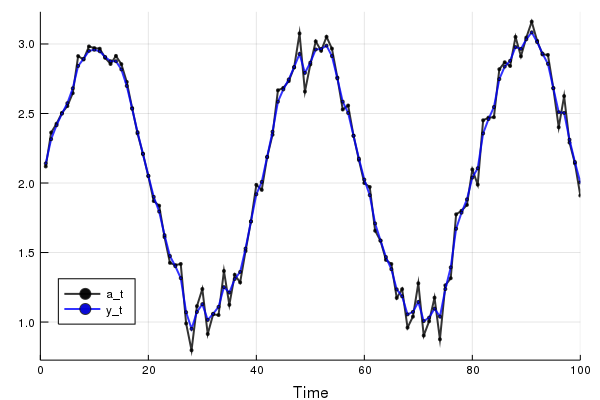

In [4]:
gr(fmt=:png);

# set seed and generate a_t sequence
Random.seed!(123)
n = 100
a_seq = sin.(range(0,  5 * pi, length = n)) .+ 2 + 0.1 * randn(n)

function plot_simulation(;γ=0.8, m=1, h=1., y_m=2.)
  d = γ * [1, -1]
  y_m = [y_m]

  testlq = LQFilter(d, h, y_m)
  y_hist, L, U, y = optimal_y(testlq, a_seq)
  y = y[end:-1:1]  # reverse y

  # plot simulation results
  time = 1:length(y)
  plt = plot(time, a_seq / h, lw=2, color=:black, alpha=0.8, marker = :circle,
             markersize = 2, label="a_t")
  plot!(plt, time, y, lw=2, color=:blue, marker = :circle,  markersize = 2, alpha=0.8,
        label="y_t")
  plot!(plt, xlabel="Time", grid=true, xlim=(0,maximum(time)), legend=:bottomleft)
end

plot_simulation()

Here’s what happens when we change $ \gamma $ to 5.0

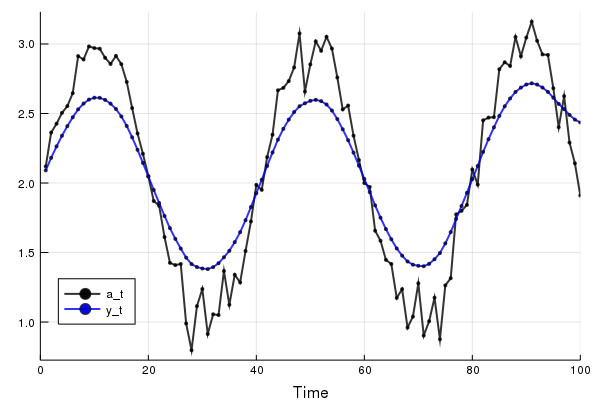

In [5]:
plot_simulation(γ=5.0)

And here’s $ \gamma = 10 $

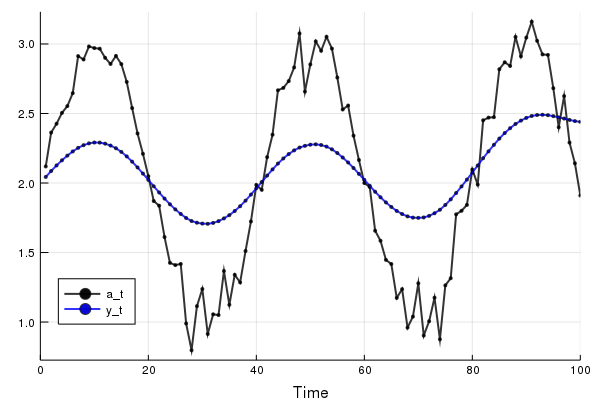

In [6]:
plot_simulation(γ=10.0)

## Exercises

### Exercise 1

Consider solving a discounted version $ (\beta < 1) $ of problem
[(1)](#equation-oneone), as follows

Convert [(1)](#equation-oneone) to the undiscounted problem [(22)](#equation-oneoneprime)

Let the solution of [(22)](#equation-oneoneprime) in feedback form be

$$
(1 - \tilde \lambda_1 L)\, \cdots\, (1 - \tilde \lambda_m L) \tilde y_t =
\sum^m_{j=1} \tilde A_j \sum^\infty_{k=0} \tilde \lambda^k_j \tilde a_{t+k}
$$

or


<a id='equation-estar'></a>
$$
\tilde y_t = \tilde f_1 \tilde y_{t-1} + \cdots + \tilde f_m \tilde y_{t-m} +
\sum^m_{j=1} \tilde A_j \sum^\infty_{k=0} \tilde \lambda^k_j \tilde a_{t+k} \tag{25}
$$

Here

- $ h + \tilde d (z^{-1}) \tilde d (z) = \tilde c (z^{-1}) \tilde c (z) $  
- $ \tilde c (z) = [(-1)^m \tilde z_0 \tilde z_1 \cdots \tilde z_m ]^{1/2} (1 - \tilde \lambda_1 z) \cdots (1 - \tilde \lambda_m z) $  


where the $ \tilde z_j $ are the zeros of $ h +\tilde d (z^{-1})\, \tilde d(z) $

Prove that [(25)](#equation-estar) implies that the solution for $ y_t $ in feedback form is

$$
y_t = f_1 y_{t-1} + \ldots + f_m y_{t-m} + \sum^m_{j=1} A_j
\sum^\infty_{k=0} \beta^k \lambda^k_j a_{t+k}
$$

where $ f_j = \tilde f_j \beta^{-j/2}, A_j = \tilde A_j $, and $ \lambda_j = \tilde \lambda_j \beta^{-1/2} $

### Exercise 2

Solve the optimal control problem, maximize

$$
\sum^2_{t=0}\ \Bigl\{a_t y_t - {1 \over 2} [(1 - 2 L) y_t]^2\Bigr\}
$$

subject to $ y_{-1} $ given, and $ \{ a_t\} $ a known bounded sequence

Express the solution in the “feedback form” [(20)](#equation-onefifteen), giving numerical values for the coefficients

Make sure that the boundary conditions [(5)](#equation-onefive) are satisfied

(Note: this problem differs from the problem in the text in one important way: instead of $ h > 0 $ in [(1)](#equation-oneone), $ h = 0 $. This has an important influence on the solution.)

### Exercise 3

Solve the infinite time optimal control problem to maximize

$$
\lim_{N \rightarrow \infty}
\sum^N_{t=0}\, -\, {1 \over 2} [(1 -2 L) y_t]^2,
$$

subject to $ y_{-1} $ given. Prove that the solution is

$$
y_t = 2y_{t-1} = 2^{t+1} y_{-1} \qquad t > 0
$$

### Exercise 4

Solve the infinite time problem, to maximize

$$
\lim_{N \rightarrow \infty}\ \sum^N_{t=0}\ (.0000001)\, y^2_t - {1 \over 2}
[(1 - 2 L) y_t]^2
$$

subject to $ y_{-1} $ given. Prove that the solution $ y_t = 2y_{t-1} $  violates condition [(12)](#equation-onesix), and so
is not optimal

Prove that the optimal solution is approximately $ y_t = .5 y_{t-1} $